In [1]:
import sys
import os
from pathlib import Path

# Handling the scenario where __file__ might not be defined
if '__file__' in globals():
    # If __file__ is defined, use it to get the current directory
    current_dir = Path(os.path.dirname(os.path.abspath(__file__)))
else:
    # If __file__ is not defined, fall back to the current working directory
    current_dir = Path(os.getcwd())

# Calculate the parent directory
parent_dir = current_dir.parent

# Append the parent directory to sys.path
sys.path.append(str(parent_dir))


In [2]:
import geopandas as gpd
import requests
import os
from shapely.geometry import Polygon, LineString, MultiLineString
import io
import osmnx as ox
from shapely import Point
from mapclassify import greedy
import momepy
import shapely
from shapely.ops import split, snap, unary_union


In [3]:
local_crs = 27700
place = "test_OS"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [4]:
latlng = (lat, lng)

In [5]:
if not os.path.exists(f'../output/{place}'):
    os.makedirs(f'../output/{place}')

## part 1: Find limits of cells to download

In [6]:
buffer = gpd.GeoDataFrame(index=[0], geometry=[Point(lng, lat)], crs=4326).to_crs(local_crs).buffer((radius+5)*1000).to_crs(4326)

In [7]:
buffer.explore()

In [8]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

/tmp/ipykernel_12550/2221155826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})


In [9]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

water_gdf = water_gdf.reset_index(drop=True)

In [10]:
water_gdf.to_parquet(f"../output/{place}/water.pq")

In [11]:
buffer = gpd.GeoDataFrame(geometry=buffer, crs=4326)

In [12]:
if country == None:
    world_poly = gpd.read_file(f"../input/{place}_study_area.shp")
else:
    world_poly = gpd.read_file(f"../input/{country}_study_area.shp")

In [13]:
study_area = gpd.overlay(world_poly, buffer, how='intersection').overlay(water_gdf, how='difference')

In [14]:
downloaded_gdf = gpd.read_parquet("../input/gitignore/os-buildings/joint_buildings.pq")

In [15]:
downloaded_gdf = gpd.sjoin(downloaded_gdf.to_crs(4326), buffer, how="inner", op="intersects")

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

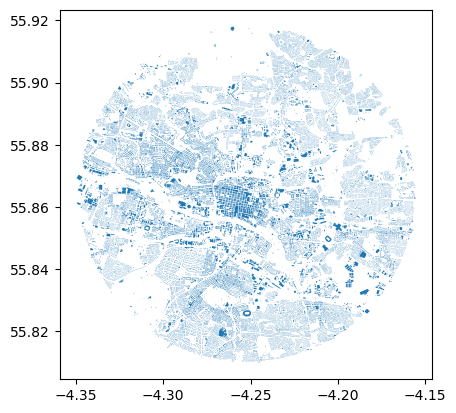

In [16]:
downloaded_gdf.plot()

In [17]:
streets = gpd.read_parquet("../input/gitignore/os-roads/merged_roads.parquet")

In [18]:
streets = streets.to_crs(4326)

In [19]:
# List of all column names to be dropped
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop the columns
streets = streets.drop(columns=columns_to_drop)

In [20]:
streets = gpd.sjoin(streets, buffer, how="inner", op="intersects")

/users/wjb22189/.conda/envs/momepy/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
# streets.explore()

In [22]:
streets = streets.drop(columns="index_right")

In [23]:
streets = streets.explode()

/tmp/ipykernel_12550/958103756.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets = streets.explode()


In [34]:
import geopandas as gpd
from shapely import wkb

# Assuming 'gdf' is your GeoDataFrame and it has a 'geometry' column.

def convert_to_2d(geom):
    # Convert the geometry to WKB and then back to a geometry object
    return wkb.loads(wkb.dumps(geom, output_dimension=2))

# Apply this conversion to all geometry objects in the GeoDataFrame
downloaded_gdf['geometry'] = downloaded_gdf['geometry'].apply(convert_to_2d)

streets['geometry'] = streets['geometry'].apply(convert_to_2d)

In [35]:
downloaded_gdf.to_parquet(f"../output/{place}/buildings_raw.pq")

In [36]:
streets.to_parquet(f"../output/{place}/streets_raw.pq")

In [27]:
osm_graph= ox.graph.graph_from_polygon(buffer.geometry[0], network_type='all', custom_filter='["railway"~"rail"]["tunnel"!="yes"]')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rail = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rail.head()

# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rail.columns if col != 'geometry']

# Drop these columns
rail = rail.drop(columns=columns_to_drop).reset_index(drop=True)

# Assuming your GeoDataFrame is named 'gdf'
rail_strings = []
for geometry in rail.geometry:
    if geometry.geom_type == 'LineString':
        rail_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        rail_strings.extend(list(geometry))
        
collection = shapely.GeometryCollection(rail_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
rail_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

In [28]:
rail_noded_gdf.explore()

In [29]:
rail_noded_gdf.to_parquet(f"../output/{place}/rail_raw.pq")

In [30]:
study_area.to_parquet((f"../output/{place}/study_area.pq"))

<Axes: >

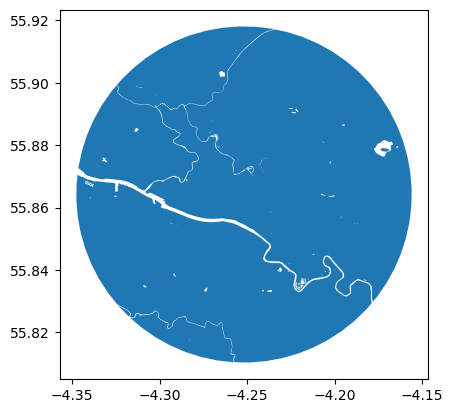

In [31]:
study_area.plot()

In [ ]:
rivers= ox.graph.graph_from_polygon(buffer.geometry[0], network_type='drive', truncate_by_edge=True, retain_all=True)
rivers = ox.projection.project_graph(osm_graph, to_crs=local_crs)
rivers = ox.graph_to_gdfs(
    ox.get_undirected(rivers),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

rivers.head()

# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in rivers.columns if col != 'geometry']

# Drop these columns
rivers = rivers.drop(columns=columns_to_drop)

rivers.plot()

rivers.to_parquet(f"../output/{place}/rivers.pq")